### **Goal of Clustering Techniques**:
The following Analysis focuses on applying different clustering methods (e.g. KMeans, Agglomerative Clustering) to perform employee segmentation, identifying distinct groups based on key characteristics. It further examines how these clusters are related to attrition, revealing insights into employee retention risks and uncovering opportunities for targeted HR strategies to improve retention.

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler

In [2]:
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
print("Initial data shape:", df.shape)

Initial data shape: (1470, 35)


In [3]:
df.head(2)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7


### **Clustering**: Customer Segementation

The goal of employee segmentation clustering is to group employees based on their inherent characteristics. Including attrition as a feature would bias the clustering process, making it treat 'Attrition' as one characteristic label rather than group them based on employee similarities naturally. By excluding attrition, we can discover meaningful patterns and identify high-risk groups without forcing the model to rely on prior labels.

### Data Information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [5]:
df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

## Pre-processing

In [7]:
df.drop_duplicates(inplace=True)
print("After removing duplicates:", df.shape)

After removing duplicates: (1470, 35)


In [8]:
len(df[df['Over18']=='Y']) # Over18 has one unique value

1470

In [9]:
# Drop columns with only one unique value
data = df.drop(columns = 'Attrition')
data = data.drop(columns = ['EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours'])

### Feature Selection (Removing Redundant Variables)

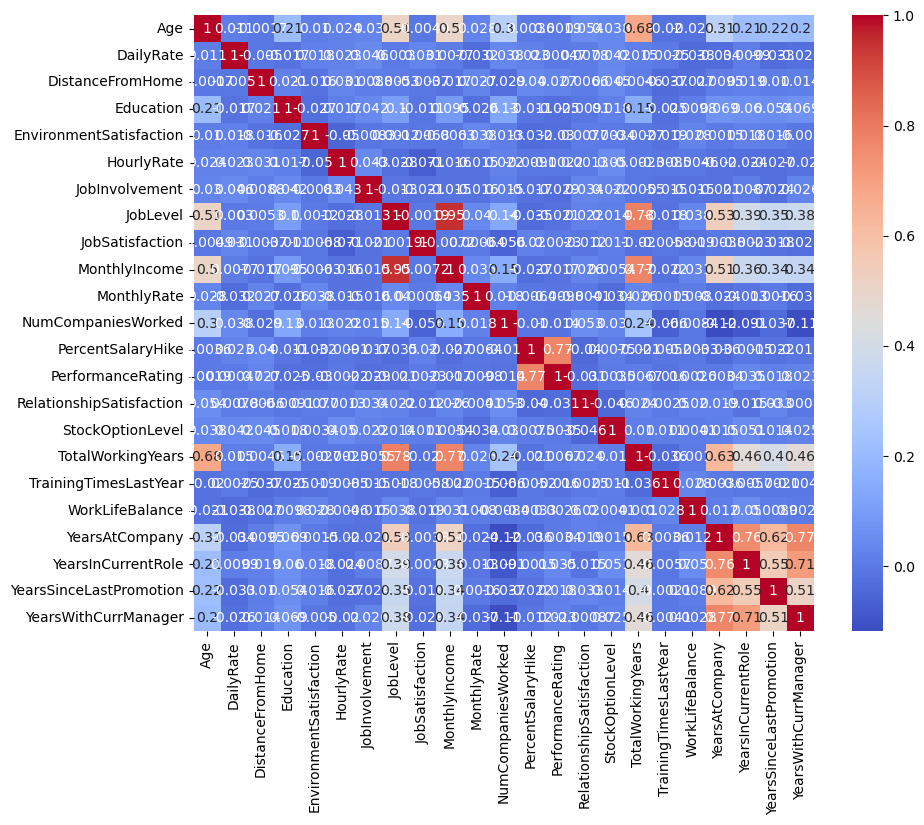

In [10]:
# Correlation
df_numeric = data.select_dtypes(include = np.number)

corr_matrix = df_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [11]:
# Income and Job Level are highly-correlated, once keep one
data = data.drop(columns = 'JobLevel')

In [12]:
# Check skewnewss
data_numeric = data.select_dtypes(include = np.number)

skewness = data_numeric.skew()
skewed_columns = skewness[abs(skewness) > 1].index
print(skewed_columns)

Index(['MonthlyIncome', 'NumCompaniesWorked', 'PerformanceRating',
       'TotalWorkingYears', 'YearsAtCompany', 'YearsSinceLastPromotion'],
      dtype='object')


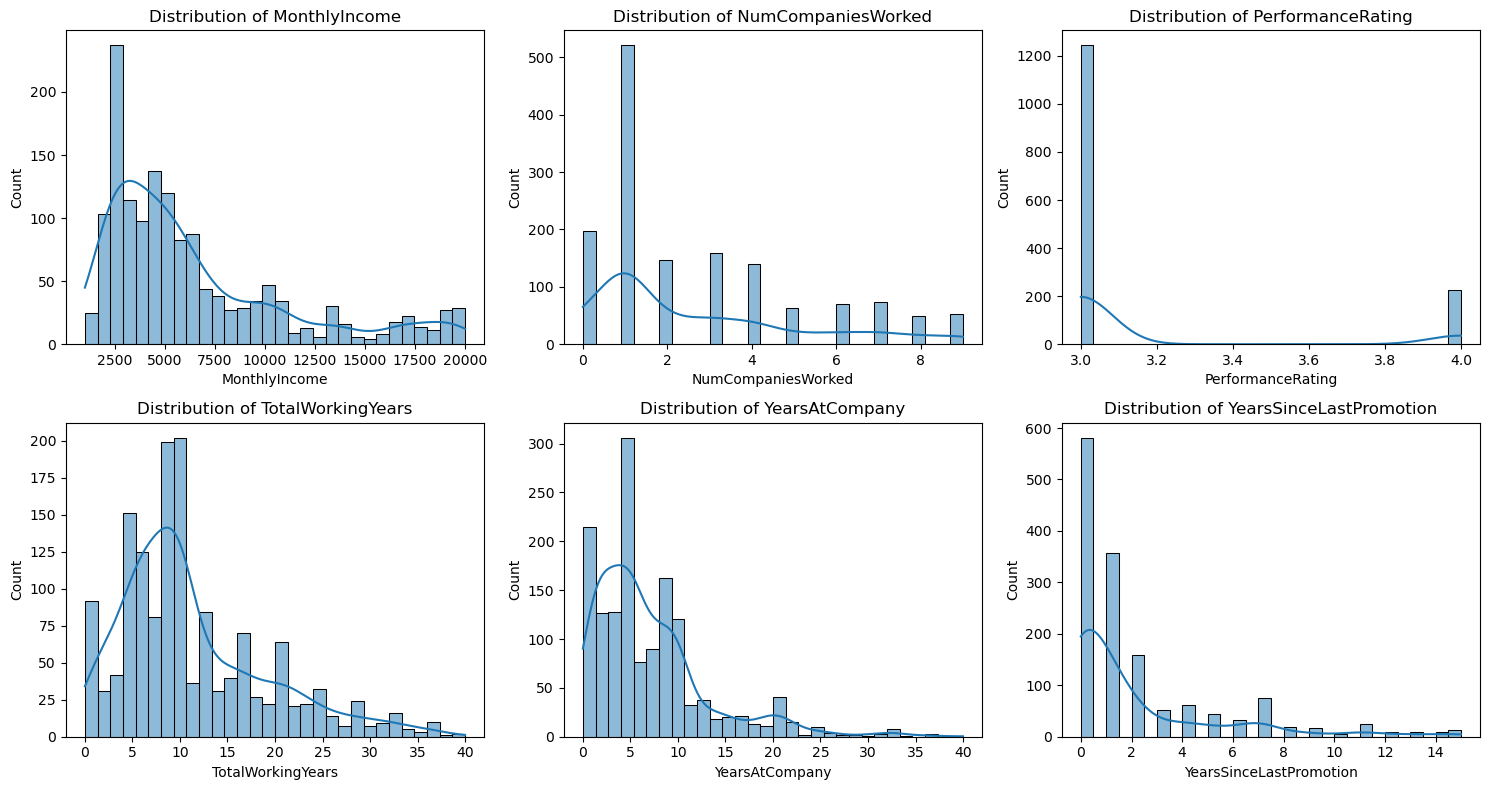

In [13]:
skewed_list = list(skewed_columns)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i, col in enumerate(skewed_list):
    sns.histplot(data[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

### To solve Skewness:
**Log Transformation + Standardization** is applied to solve skewness issue: 

Log transformation reduces positive skewness, making the data closer to a normal distribution, followed by standardization (Z-score normalization) to center the data at 0 with a variance of 1, improving model stability.

In [19]:
# Log Transformation
data_log = data.copy()

for col in skewed_columns:
    data_log[col] = np.log1p(data_log[col])

In [35]:
# One-Hot Encoding
cate_col = data_log.select_dtypes(include = 'object').columns.tolist()
print(cate_col)

data_log_encoded = pd.get_dummies(data_log, columns=cate_col, drop_first=True)
display(data_log_encoded.head(2))

['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1102,1,2,2,94,3,4,8.698514,19479,...,False,False,False,False,False,True,False,False,True,True
1,49,279,8,1,3,61,2,2,8.543056,24907,...,False,False,False,False,True,False,False,True,False,False


In [21]:
# Standardization
data_log_encoded_std = data_log_encoded.copy()

scaler = StandardScaler()
num_col = data_log_encoded.select_dtypes(include = ['int64', 'float64']).columns
data_log_encoded_std[num_col] = scaler.fit_transform(data_log_encoded_std[num_col])
print(data_log_encoded_std.head(2))

        Age  DailyRate  DistanceFromHome  Education  EnvironmentSatisfaction  \
0  0.446350   0.742527         -1.010909  -0.891688                -0.660531   
1  1.322365  -1.297775         -0.147150  -1.868426                 0.254625   

   HourlyRate  JobInvolvement  JobSatisfaction  MonthlyIncome  MonthlyRate  \
0    1.383138        0.379672         1.153254       0.219493     0.726020   
1   -0.240677       -1.026167        -0.660853      -0.014600     1.488876   

   ...  JobRole_Laboratory Technician  JobRole_Manager  \
0  ...                          False            False   
1  ...                          False            False   

   JobRole_Manufacturing Director  JobRole_Research Director  \
0                           False                      False   
1                           False                      False   

   JobRole_Research Scientist  JobRole_Sales Executive  \
0                       False                     True   
1                        True           

In [22]:
print(data_log_encoded_std.columns)

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'Gender_Male',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturing Director',
       'JobRole_Research Director', 'JobRole_Research Scientist',
       

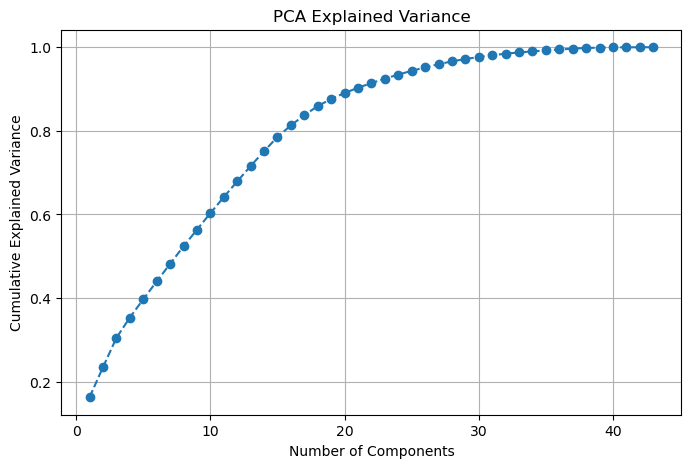

In [50]:
# Check Whether PCA will work well
pca = PCA()
data_log_encoded_std_pca = pca.fit_transform(data_log_encoded_std)

# Calculate Cumulative Explained Variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Visualize
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

In [51]:
pca = PCA(n_components=0.90)
data_log_encoded_std_pca = pca.fit_transform(data_log_encoded_std)

print(f"Number of Features After PCA: {data_log_encoded_std_pca.shape[1]}")

Number of Features After PCA: 21


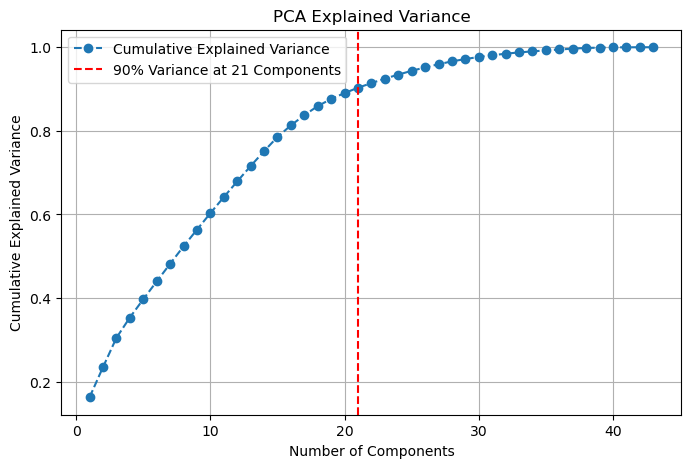

In [87]:
# Visualization
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA()
data_log_encoded_std_pca = pca.fit_transform(data_log_encoded_std)

explained_variance = np.cumsum(pca.explained_variance_ratio_)

n_components_90 = np.argmax(explained_variance >= 0.90) + 1

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', label='Cumulative Explained Variance')
plt.axvline(n_components_90, color='r', linestyle='--', label=f'90% Variance at {n_components_90} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

### About PCA Component Name:
We know that the feature contributions of each principal component (PC) in PCA are distributed. In the `pca.components_` matrix, each principal component has different weights for various features, rather than being influenced by only a single feature. However, to facilitate the interpretation of each PC, I choose to analyze the most influential features for each PC and name the principal components based on the original feature with the highest impact.

In [32]:
# Highest Weight Original Feature Name
pca = PCA(n_components=0.90)
data_log_encoded_std_pca = pca.fit_transform(data_log_encoded_std)

feature_names = data_log_encoded_std.columns
pca_components = pd.DataFrame(pca.components_, columns=feature_names) 

top_features = []
for i in range(pca_components.shape[0]):  
    top_feature = pca_components.iloc[i].abs().idxmax()
    top_features.append(top_feature)

df_pca_named = pd.DataFrame(data_log_encoded_std_pca, columns=top_features)

print(df_pca_named.shape)
display(df_pca_named.head(2))

(1470, 21)


,YearsAtCompany,PerformanceRating,PercentSalaryHike,StockOptionLevel,JobSatisfaction,WorkLifeBalance,DistanceFromHome,EnvironmentSatisfaction,TrainingTimesLastYear,RelationshipSatisfaction,...,WorkLifeBalance,DistanceFromHome,HourlyRate,Education,NumCompaniesWorked,NumCompaniesWorked,YearsSinceLastPromotion,Age,EducationField_Life Sciences,BusinessTravel_Travel_Rarely
0,-0.086031,-1.601322,0.283356,0.149189,0.355501,-2.417656,1.480369,1.139395,0.485960,2.551032,...,1.838196,-1.105913,0.433634,0.517313,0.144145,1.408396,1.234789,0.930982,0.144664,-0.006141
1,1.098988,2.789668,1.582436,-1.281642,-0.013239,1.108357,0.338176,-1.437423,1.114696,-0.067496,...,-0.416155,-1.725943,0.083987,0.068751,-0.056478,-1.296319,0.087845,1.180763,0.786145,0.620385


In [33]:
# Highest Weight Original Feature Name + Weight
pca = PCA(n_components=0.90)
data_log_encoded_std_pca = pca.fit_transform(data_log_encoded_std)

feature_names = data_log_encoded_std.columns
pca_components = pd.DataFrame(pca.components_, columns=feature_names)

top_features = []
for i in range(pca_components.shape[0]):  
    max_feature = pca_components.iloc[i].abs().idxmax()
    max_weight = pca_components.iloc[i][max_feature]
    top_features.append(f"{max_feature} ({max_weight:.2f})")

df_pca_named1 = pd.DataFrame(data_log_encoded_std_pca, columns=top_features)

print(df_pca_named1.shape)
display(df_pca_named1.head(2))

(1470, 21)


,YearsAtCompany (0.43),PerformanceRating (0.52),PercentSalaryHike (0.49),StockOptionLevel (0.65),JobSatisfaction (0.51),WorkLifeBalance (0.54),DistanceFromHome (0.59),EnvironmentSatisfaction (-0.64),TrainingTimesLastYear (0.55),RelationshipSatisfaction (-0.51),...,WorkLifeBalance (0.51),DistanceFromHome (0.51),HourlyRate (0.62),Education (-0.58),NumCompaniesWorked (-0.50),NumCompaniesWorked (0.47),YearsSinceLastPromotion (-0.70),Age (0.59),EducationField_Life Sciences (0.74),BusinessTravel_Travel_Rarely (-0.70)
0,-0.086031,-1.601322,0.283356,0.149189,0.355501,-2.417656,1.480369,1.139395,0.485960,2.551032,...,1.838196,-1.105913,0.433634,0.517313,0.144145,1.408396,1.234789,0.930982,0.144664,-0.006141
1,1.098988,2.789668,1.582436,-1.281642,-0.013239,1.108357,0.338176,-1.437423,1.114696,-0.067496,...,-0.416155,-1.725943,0.083987,0.068751,-0.056478,-1.296319,0.087845,1.180763,0.786145,0.620385


In [34]:
df_pca = df_pca_named.copy()

## Apply Clustering Techniques

Mutiple Clustering Techniques are applied, including **KMeans, Agglomerative Clustering, GMM, Spectural Clustering, DBSCAN, and KMean Shifts**.

For **KMeans, Agglomerative, GMM and Spectral Clustering** which are required to **select k value** before clustering, I calculated their silhouette scores at different k values (from 2-6) and created the line chart to visualize the results.

In [54]:
## Select Best Model According to Silhouette Scores
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Try different k value: From 2-6
cluster_range = range(2, 7)
silhouette_scores_pca = {"K-Means": [], "GMM": [], "Agglomerative": [], "Spectral": []}

# Try K-Means、GMM、Agglomerative and Spectral Clustering
for k in cluster_range:
    # K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_clusters = kmeans.fit_predict(df_pca)
    kmeans_score = silhouette_score(df_pca, kmeans_clusters)
    silhouette_scores_pca["K-Means"].append(kmeans_score)

    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_clusters = gmm.fit_predict(df_pca)
    gmm_score = silhouette_score(df_pca, gmm_clusters)
    silhouette_scores_pca["GMM"].append(gmm_score)

    # Agglomerative
    agglo = AgglomerativeClustering(n_clusters=k)
    agglo_clusters = agglo.fit_predict(df_pca)
    agglo_score = silhouette_score(df_pca, agglo_clusters)
    silhouette_scores_pca["Agglomerative"].append(agglo_score)

    # Spectral Clustering
    spectral = SpectralClustering(n_clusters=k, random_state=42)
    spectral_clusters = spectral.fit_predict(df_pca)
    spectral_score = silhouette_score(df_pca, spectral_clusters)
    silhouette_scores_pca["Spectral"].append(spectral_score)

In [382]:
# Print Best Silhouette Scores for Each Model
best_scores_pca = {
    "Best K-Means": max(silhouette_scores_pca["K-Means"]),
    "Best GMM": max(silhouette_scores_pca["GMM"]),
    "Best Agglomerative": max(silhouette_scores_pca["Agglomerative"]),
    "Best Spectral": max(silhouette_scores_pca["Spectral"]),
}

best_scores_pca

{'Best K-Means': 0.11347024896053307,
 'Best GMM': 0.09980688187997301,
 'Best Agglomerative': 0.09265200180034355,
 'Best Spectral': 0.12303682291768457}

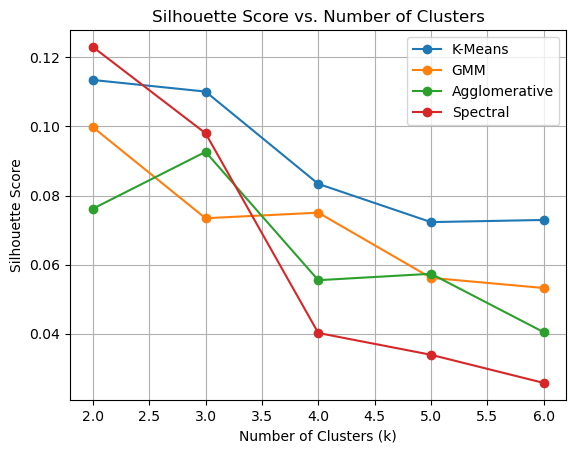

In [309]:
# Plot Line Chart to visualize the results at each k
algorithms = ["K-Means", "GMM", "Agglomerative", "Spectral"]
for algo in algorithms:
    plt.plot(cluster_range, silhouette_scores_pca[algo], marker='o', label=algo)

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.legend()
plt.grid(True)
plt.show()

## Observation:
We noticed that the **highest silhouette score occurs** at **k=2 for all methods**. This is likely due to:

1. Our data contains some categorical variables, like Gender and MaritalStatus. K=2 can easily capture the primary division, leading clustering metrics like silhouette scores to reach their optimal values at K=2.

2. Even without explicit binary features, continuous HR data often follows skewed or multimodal distributions, leading to a natural global separation into two broad groups. For example, in our dataset, MonthlyIncome is right-skewed, meaning there’s a large cluster of lower/mid-range income and a smaller cluster of higher income. Clustering algorithms might first split the data into 'low-to-mid monthly income' vs. 'high monthly income' because that is the dominant structure in the dataset. Then, they tend to find a strong initial division at K=2, reflecting the dominant large-scale separation in the data.

3. In lower-dimensional HR data (eg. salary, performance, tenure), the data may have only one dominant principal component, making K=2 sufficient to capture the primary separation. While in higher-dimensional data, a larger K might be necessary to properly segment the data, but in low dimensions, increasing K may not significantly improve clustering results.

The above analysis shows that **K=2 is not necessarily the best choice** because it may **oversimplify the data** and could **fail to provide deeper business insights**.

## **KMeans Clustering**

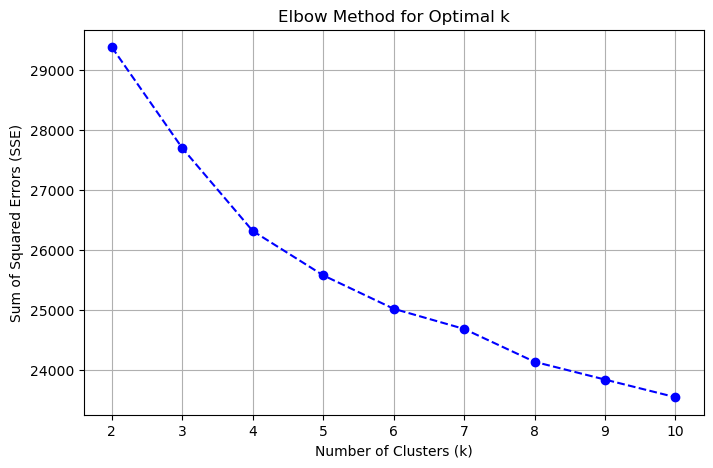

In [55]:
# Elbow Method to Find Optimal K
from sklearn.cluster import KMeans

sse = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pca)
    sse.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for Optimal k")
plt.grid()
plt.show()

Elbow Method shows that the **optimal k** should occur at **k=4 or 5**.

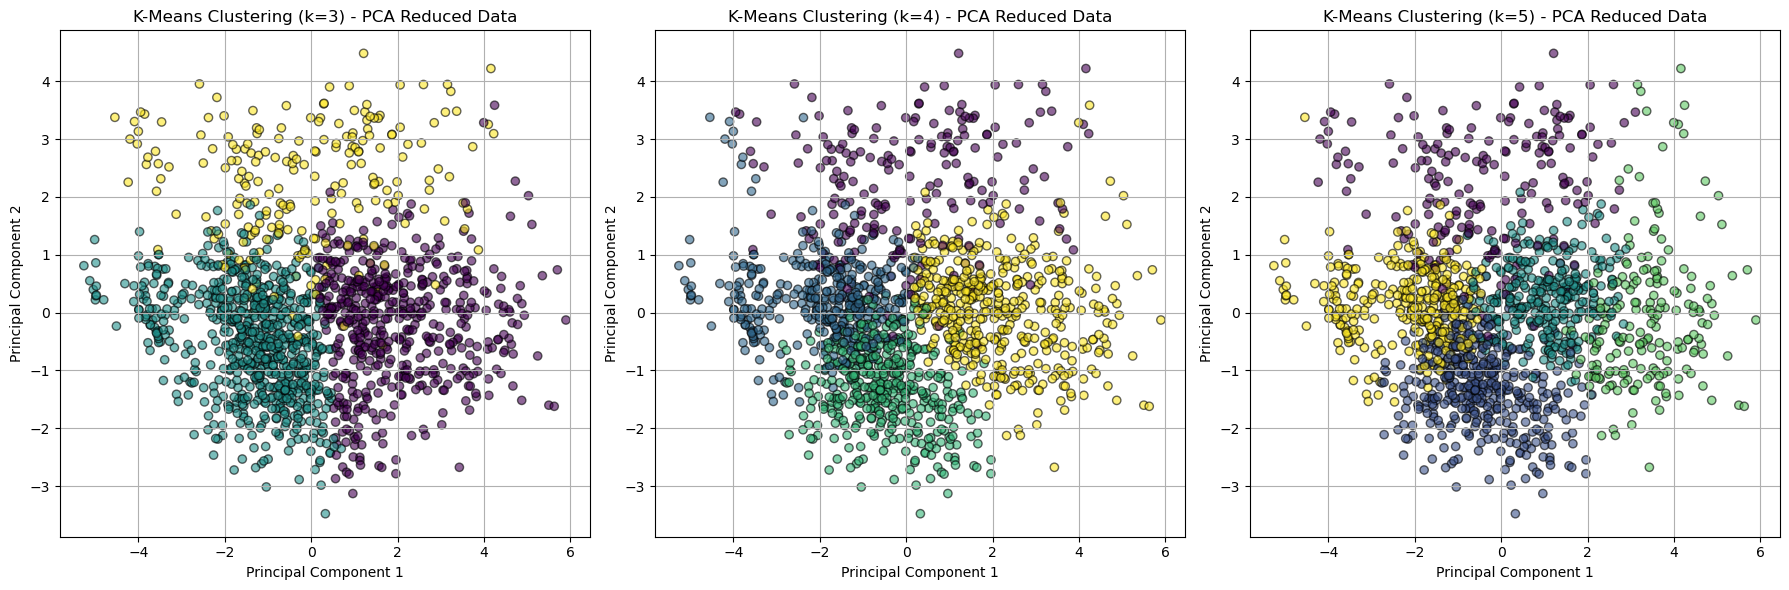

In [38]:
## Visualize Scatter Plot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

k_values = [3, 4, 5]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
df_pca_np = df_pca.to_numpy()

for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(df_pca_np)
    
    pca_2d = df_pca_np[:, :2] 
    
    axes[i].scatter(pca_2d[:, 0], pca_2d[:, 1], c=clusters, cmap='viridis', alpha=0.6, edgecolors='k')
    axes[i].set_xlabel("Principal Component 1")
    axes[i].set_ylabel("Principal Component 2")
    axes[i].set_title(f"K-Means Clustering (k={k}) - PCA Reduced Data")
    axes[i].grid()

plt.tight_layout()
plt.show()

## Observation:
From the K-Means clustering result graph, **k=3 seems to be a more reasonable choice**, because:
1. **Cluster Separation:**  
- In the figure with **k=3**, although there is still some overlap, the boundaries of the three groups are relatively clear and the overall structure is relatively stable. The distribution of points in each group is uniform and there is no excessive fragmentation.
- In the graphs of **k=4** and **k=5**, groups begin to become more dispersed, especially when **k=5**, where multiple groups show significant overlap, which may indicate that some groups are artificially divided rather than naturally formed.
2. **Cluster Compactness:**  
- When **k=3**, the data points within each cluster appear relatively dense, conforming to the expected cluster structure of K-Means.
- When **k=4** and **k=5**, the point distribution of some clusters is relatively loose and does not form obvious dense centers, especially when **k=5**, the boundaries of multiple clusters become blurred, indicating that the data may have been excessively subdivided.
3. **Business Interpretability:**  
- Choosing **k=3** may be more in line with business needs, as we want to clearly divide employees so that each group can provide valuable insights in attrition analysis.
- In the case of **k=4** and **k=5**, some redundant clustering may be introduced, making business interpretation more complex without bringing significant gains.


Overall, **k=3** is a more reasonable choice because it performs well in terms of cluster separation clarity, compactness, and business interpretability, while k=4 and k=5 may introduce too much overlap or unnecessary segmentation.

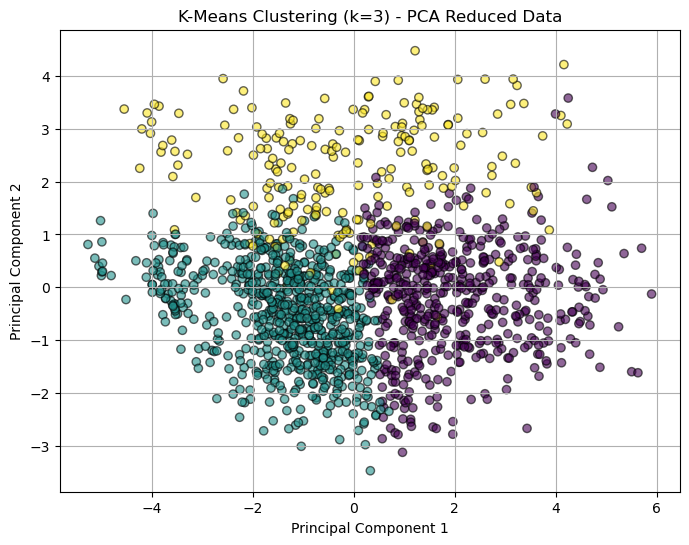

In [59]:
# Optimal K=3

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_pca_np)

pca_2d = df_pca_np[:, :2]
# Visualize Clustering Results Using Top 2 Components
plt.figure(figsize=(8, 6))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=clusters, cmap='viridis', alpha=0.6, edgecolors='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"K-Means Clustering (k={optimal_k}) - PCA Reduced Data")
plt.grid()
plt.show()

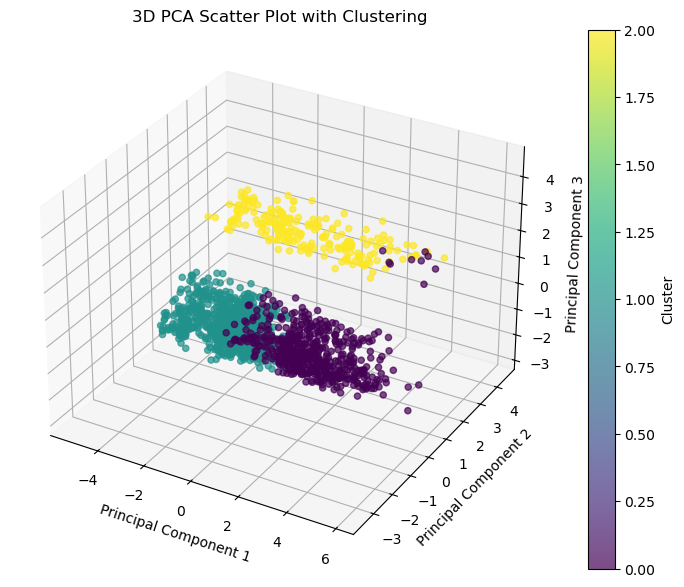

In [60]:
from mpl_toolkits.mplot3d import Axes3D

pca_3d = df_pca_np[:, :3]

# Plot 3D PCA Scatter Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_3d[:, 0], pca_3d[:, 1], pca_3d[:, 2], c=clusters, cmap='viridis', alpha=0.7)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("3D PCA Scatter Plot with Clustering")

plt.colorbar(scatter, ax=ax, label="Cluster")
plt.show()

In [61]:
# Print Silhouette Score
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_pca)

silhouette_avg = silhouette_score(df_pca, clusters)
silhouette_avg

0.11010380302583932

In [39]:
## Attrition Rate in Each Cluster
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df_pca)

# Calculate Attrition Rate for Each Cluster
attrition_rates = df.groupby("Cluster")["Attrition"].value_counts(normalize=True).unstack() * 100
attrition_rates

Attrition,No,Yes
Cluster,,
0,90.211132,9.788868
1,79.644809,20.355191
2,82.949309,17.050691


In [63]:
# Data Points Distribution in Each Cluster
df_clustering = df.copy()
df_count = df_clustering.groupby(by=["Cluster"]).size().reset_index(name="counts")
df_count

,Cluster,counts
0,0,521
1,1,732
2,2,217


## **Agglomerative Clustering**

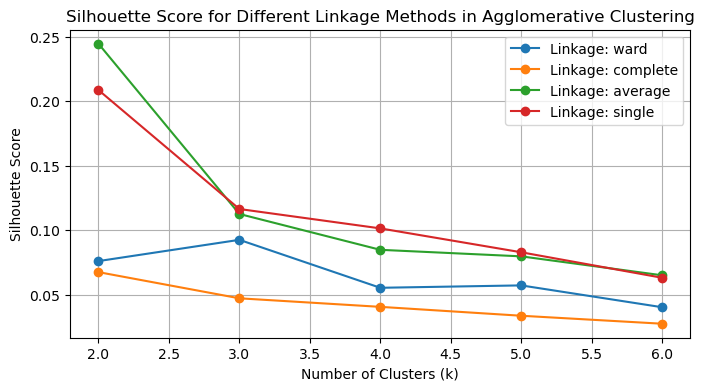

In [40]:
# Try Different Linkage Methods
linkage_methods = ["ward", "complete", "average", "single"]

# k range
cluster_range = range(2, 7)

silhouette_scores = {method: [] for method in linkage_methods}

# Calculate Silhouette Score
for method in linkage_methods:
    for k in cluster_range:
        agglo = AgglomerativeClustering(n_clusters=k, linkage=method)
        clusters = agglo.fit_predict(df_pca)
        score = silhouette_score(df_pca, clusters)
        silhouette_scores[method].append(score)

# Plot Silhouette Score for Different Linkage Methods
plt.figure(figsize=(8, 4))
for method in linkage_methods:
    plt.plot(cluster_range, silhouette_scores[method], marker='o', linestyle='-', label=f"Linkage: {method}")

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different Linkage Methods in Agglomerative Clustering")
plt.legend()
plt.grid()
plt.show()

From above line chart, **'average' and 'single' linkage** have **higher silhouette score** compared to 'ward' and 'complete' linkage. Thus, I continue to test which linkage offers best result.

### **Average Linkage:**

In [45]:
# Average Linkage:
from sklearn.cluster import AgglomerativeClustering

# Agglomerative Clustering (k=3, Average Linkage)
agglo = AgglomerativeClustering(n_clusters=3, linkage='average')
df["Cluster"] = agglo.fit_predict(df_pca)

# Calculate Attrition Rate for Each Cluster
attrition_rates = df.groupby("Cluster")["Attrition"].value_counts(normalize=True).unstack() * 100
attrition_rates = attrition_rates.fillna(0)  # Fill NaN by 0

In [46]:
# Print Silhouette Score
agglo = AgglomerativeClustering(n_clusters=3, linkage='average')
clusters = agglo.fit_predict(df_pca)

silhouette_avg = silhouette_score(df_pca, clusters)
silhouette_avg

0.11268617474647522

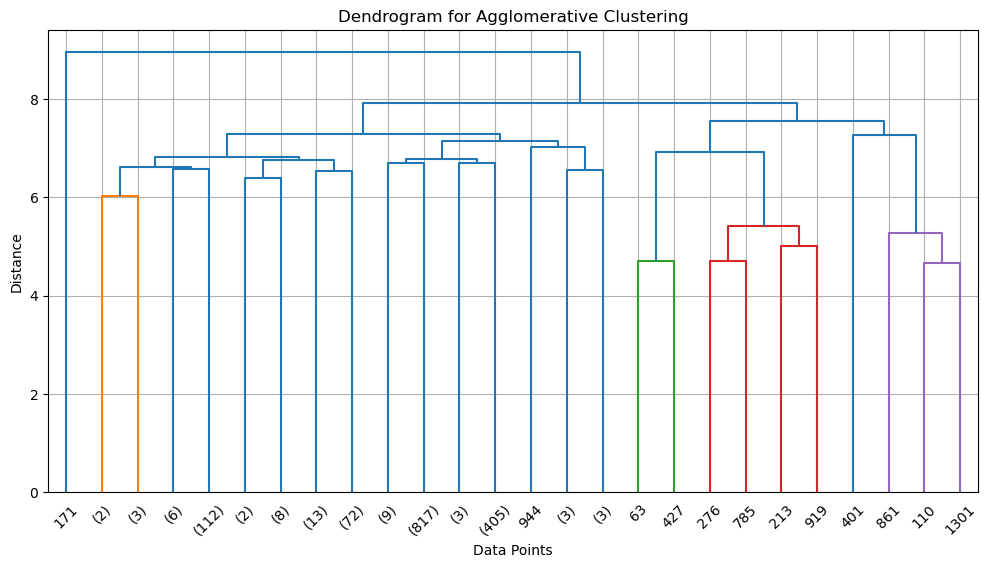

In [52]:
# Dendrogram
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

linked = sch.linkage(df_pca, method="average")

plt.figure(figsize=(12, 6))
sch.dendrogram(linked, truncate_mode="level", p=5)
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.title("Dendrogram for Agglomerative Clustering")
plt.grid()
plt.show()

In [47]:
# Data Point Distribution in Each Cluster
df_clustering = df.copy()
df_count = df_clustering.groupby(by=["Cluster"]).size().reset_index(name="counts")
df_count

,Cluster,counts
0,0,10
1,1,1
2,2,1459


## Observation:

Although the Dendrogram of Average Linkage shows that it should be a reasonable way of clustering, the imbalaced data distribution in clusters illustrates problems. This is likely due to Average Linkage relies on the average distance between all points, which may result in some clusters not being tightly packed in HR data, especially when the data has different scales. For example, if some of the HR data consists of high salary and high performance, while others consist of low salary and low performance, the Average Linkage may create an intermediate cluster between these two groups instead of clearly separating them.

### **Single Linkage:**

In [48]:
# Agglomerative Clustering (k=3, Single Linkage)
agglo = AgglomerativeClustering(n_clusters=3, linkage='single')
df["Cluster"] = agglo.fit_predict(df_pca)

# Calculate Attrition Rate for Each Cluster
attrition_rates = df.groupby("Cluster")["Attrition"].value_counts(normalize=True).unstack() * 100
attrition_rates = attrition_rates.fillna(0)  # Fill NaN by 0

In [49]:
# Print Silhouette Score
agglo = AgglomerativeClustering(n_clusters=3, linkage='average')
clusters = agglo.fit_predict(df_pca)

silhouette_avg = silhouette_score(df_pca, clusters)
silhouette_avg

0.11268617474647522

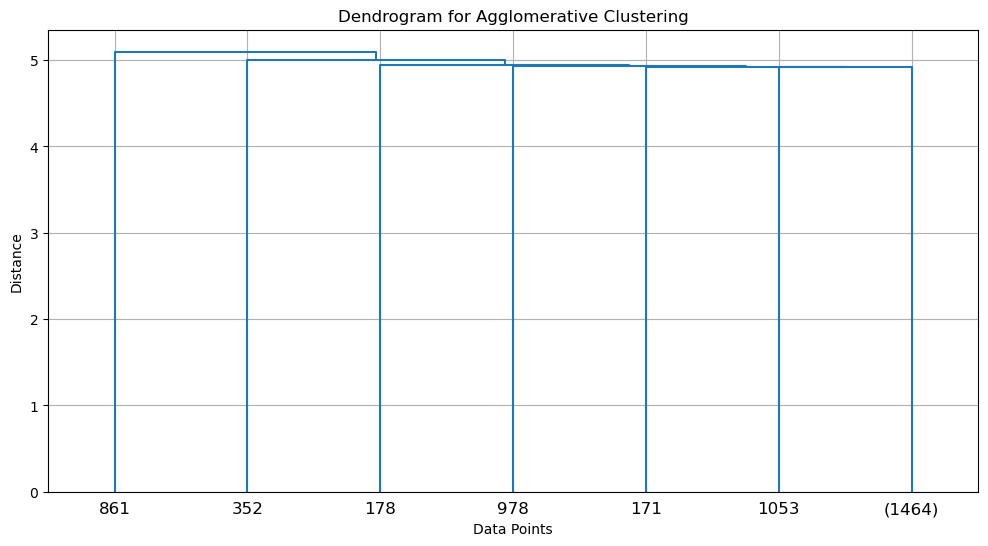

In [53]:
# Dendrogram for single linkage: Shows Error
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

linked = sch.linkage(df_pca, method="single")

plt.figure(figsize=(12, 6))
sch.dendrogram(linked, truncate_mode="level", p=5) 
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.title("Dendrogram for Agglomerative Clustering")
plt.grid()
plt.show()

In [50]:
# Data Point Distribution in Each Cluster
df_clustering = df.copy()
df_count = df_clustering.groupby(by=["Cluster"]).size().reset_index(name="counts")
df_count

,Cluster,counts
0,0,1468
1,1,1
2,2,1


## Observation:
The dendrogram shows a chain like structure which should not be a reasonable structure for clustering, while the distribution of data points in each cluster also illustrates the imbalanced segmentation. No matter from the dendrogram or the data point distribution of single linkage alggomerative clustering shows that it is not an ideal choice. This is because:

When performing hierarchical clustering, **Single Linkage** calculates the minimum distance between two clusters, which can easily form a chaining structure, resulting in unsatisfactory clustering performance. To be specific, some data points may gradually connect into **a long chain**, causing the entire data to be mistakenly classified into a large cluster rather than a clear group.

Thus, it results to obtain highly imbalanced clusters, which is the cause for our dataset that most employees are clustered into a large cluster, while other points form many small, isolated clusters.

## **Mean Shift**

In [59]:
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score

mean_shift = MeanShift()
mean_shift_clusters = mean_shift.fit_predict(df_pca)

# K value
num_clusters = len(set(mean_shift_clusters)) - (1 if -1 in mean_shift_clusters else 0)

# Calculate silhouette score
if num_clusters > 1:
    mean_shift_score = silhouette_score(df_pca, mean_shift_clusters)
else:
    mean_shift_score = -1 # Ensure at least 2 clusters

print(f"Number of clusters (k) = {num_clusters}, Silhouette Score = {mean_shift_score:.4f}")

Number of clusters (k) = 1, Silhouette Score = -1.0000


**Mean Shift** results in only one cluster, which shows that there are issues with this method. Further exploration is required to identify the problems.

**Possible Reason 1:** Bandwidth Too Large (Over-Smoothing)

Solution: Try setting a smaller bandwidth manually

Conclusion: Based on the result below, adjustment on bandwith do not result in improvement.

In [60]:
from sklearn.cluster import estimate_bandwidth

# Estimate an appropriate bandwidth
bandwidth = estimate_bandwidth(df_pca, quantile=0.2, n_samples=500)
mean_shift = MeanShift(bandwidth=bandwidth)
mean_shift_clusters = mean_shift.fit_predict(df_pca)

In [61]:
# K value
num_clusters = len(set(mean_shift_clusters)) - (1 if -1 in mean_shift_clusters else 0)

# Calculate silhouette score
if num_clusters > 1:
    mean_shift_score = silhouette_score(df_pca, mean_shift_clusters)
else:
    mean_shift_score = -1 # Ensure at least 2 clusters

print(f"Number of clusters (k) = {num_clusters}, Silhouette Score = {mean_shift_score:.4f}")

Number of clusters (k) = 1, Silhouette Score = -1.0000


**Possible Reason 2:** Data Has No Clear Density Peaks

Mean Shift relies on detecting density peaks. If your data is evenly distributed without strong local density areas, the algorithm might detect only one single cluster.

Solution: Try checking the data distribution

Conclusion: The scatter plot below suggests that the data is relatively evenly distributed, without strongly defined density peaks, which is the reason why Mean Shift doesn't work.

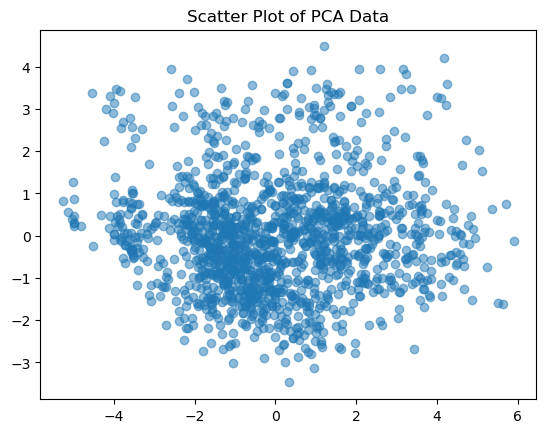

In [63]:
import matplotlib.pyplot as plt

plt.scatter(df_pca_np[:, 0], df_pca_np[:, 1], alpha=0.5)
plt.title("Scatter Plot of PCA Data")
plt.show()

## **DBSCAN**

In [57]:
dbscan_eps = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]  
dbscan_scores_pca = {}

for eps in dbscan_eps:
    dbscan = DBSCAN(eps=eps, min_samples=10)
    dbscan_clusters = dbscan.fit_predict(df_pca)
    
    # Count number of clusters selected (Exclude -1 which is noise)
    num_clusters = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)
    
    print(f"eps = {eps}: Number of clusters (k) = {num_clusters}")

eps = 2.0: Number of clusters (k) = 0
eps = 3.0: Number of clusters (k) = 0
eps = 4.0: Number of clusters (k) = 1
eps = 5.0: Number of clusters (k) = 1
eps = 6.0: Number of clusters (k) = 1
eps = 7.0: Number of clusters (k) = 1
eps = 8.0: Number of clusters (k) = 1
eps = 9.0: Number of clusters (k) = 1


Even if I change multiple eps values to try, DBSCAN still cannot find the meaningful clusters.

## **Spectral Clustering**

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
clusters = spectral.fit_predict(df_pca)

silhouette_avg = silhouette_score(df_pca, clusters)
silhouette_avg

0.10920724518745772

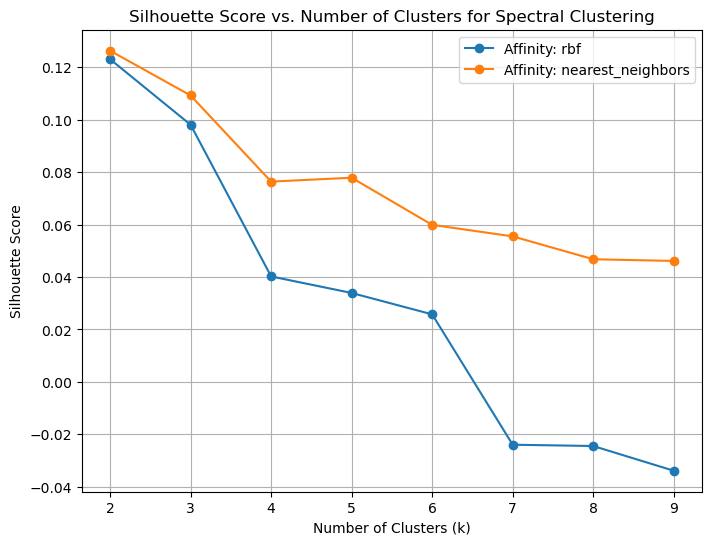

In [70]:
k_range = range(2, 10)
affinities = ["rbf", "nearest_neighbors"]
silhouette_scores = {aff: [] for aff in affinities}

for affinity in affinities:
    for k in k_range:
        clustering = SpectralClustering(n_clusters=k, affinity=affinity, random_state=42, assign_labels='kmeans')
        labels = clustering.fit_predict(df_pca)
        score = silhouette_score(df_pca, labels)
        silhouette_scores[affinity].append(score)

plt.figure(figsize=(8, 6))
for affinity in affinities:
    plt.plot(k_range, silhouette_scores[affinity], marker='o', label=f"Affinity: {affinity}")

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters for Spectral Clustering")
plt.legend()
plt.grid()
plt.show()

Even though trying different Spectral Clustering techniques, their silhouette scores are not higher than KMeans clustering, then our final model for clustering is decided to be **KMeans with k=3**.

## **Final Clustering Technique: KMeans with k=3**

In [66]:
# Even distribution of data points in each cluster
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df_pca)

# Calculate Attrition Rate for Each Cluster
attrition_rates = df.groupby("Cluster")["Attrition"].value_counts(normalize=True).unstack() * 100
attrition_rates = attrition_rates.fillna(0)  # Fill NaN by 0

df_clustering = df.copy()
df_count = df_clustering.groupby(by=["Cluster"]).size().reset_index(name="counts")
df_count

,Cluster,counts
0,0,521
1,1,732
2,2,217


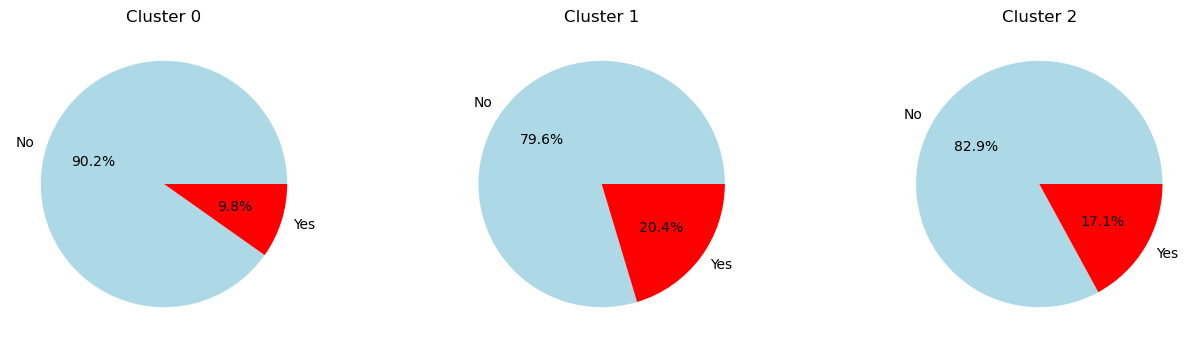

In [67]:
# Pie Chart for Attrition Rates in Each Cluster
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, cluster in enumerate(attrition_rates.index):
    axes[i].pie(attrition_rates.loc[cluster], labels=attrition_rates.columns, autopct='%1.1f%%', colors=['lightblue', 'red'])
    axes[i].set_title(f"Cluster {cluster}")

plt.show()

Even though we do not include attrition as one of the knowing labels, **attrition rates** still **differ significantly in each cluster** which indicates it is a distingushing factor.

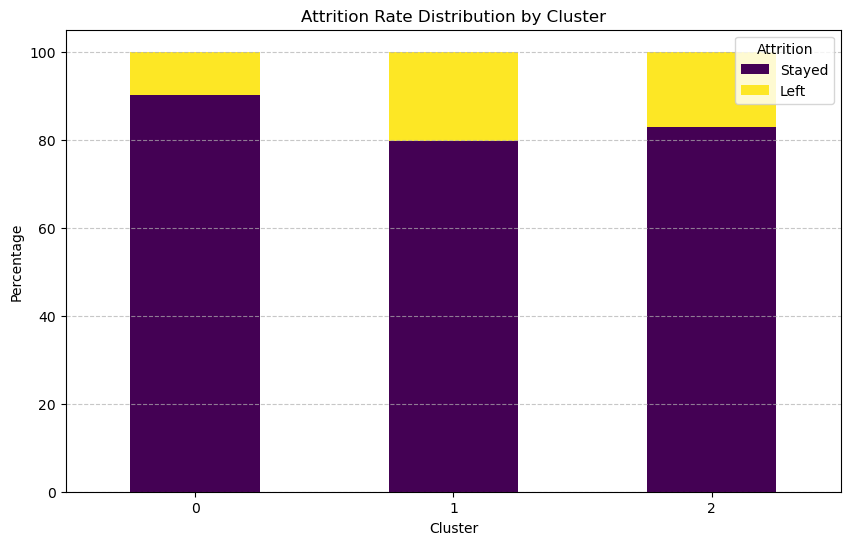

In [68]:
import matplotlib.pyplot as plt

attrition_rates.plot(kind='bar', stacked=True, figsize=(10, 6), colormap="viridis")

plt.xlabel("Cluster")
plt.ylabel("Percentage")
plt.title("Attrition Rate Distribution by Cluster")
plt.legend(title="Attrition", labels=["Stayed", "Left"])
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [69]:
# Check distribution of Attrition in original dataset
df["Attrition"].value_counts(normalize=True)

Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64

In [75]:
# Apply Kruskal-Wallis test to find important features for Attrition prediction
import pandas as pd
from scipy.stats import kruskal

# Put Attrition Back to df1
df1 = pd.concat([df[['Attrition']], data], axis=1)

# Convert Attrition to binary (if not already done elsewhere)
df1['Attrition'] = pd.get_dummies(df1['Attrition'], drop_first=True)

# Ensure Cluster is categorical
df1["Cluster"] = df["Cluster"].astype("category")

# Remove Attrition from analysis
df2 = df1.drop(columns=["Attrition"])

anova_results = {}

for feature in df2.drop(columns=["Cluster"]).columns:
    groups = [df2[df2["Cluster"] == c][feature].dropna() for c in df2["Cluster"].unique()]
    
    if all(g.nunique() == 1 for g in groups):  
        print(f"Skipping {feature}: All values are identical across clusters")
        continue
    
    if all(len(g) > 1 for g in groups):  
        try:
            p_value = kruskal(*groups).pvalue  # Kruskal-Wallis Test
            anova_results[feature] = p_value
        except ValueError as e:
            print(f"Skipping {feature} due to error: {e}")

# Sort by P value
anova_results = pd.DataFrame(anova_results.items(), columns=["Feature", "P-Value"])
anova_results = anova_results.sort_values(by="P-Value")

anova_results

,Feature,P-Value
19,PerformanceRating,5.785107e-305
25,YearsAtCompany,9.114496e-167
26,YearsInCurrentRole,6.016167e-144
28,YearsWithCurrManager,4.585594e-136
18,PercentSalaryHike,2.467417e-121
22,TotalWorkingYears,4.519319e-120
14,MonthlyIncome,2.352468e-80
27,YearsSinceLastPromotion,4.577568e-74
0,Age,4.020370e-41
5,Education,2.057408e-03


The purpose of using the **Kruskal-Wallis test** to calculate the p-value for each variable is to determine whether there is a statistically significant difference in the distribution of each feature across different **Attrition** groups. A **p-value below 0.05** suggests that the feature is important and has a significant association with **Attrition**, meaning it could be useful for predictive modeling or further analysis.

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_16016\3607635525.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df1["Cluster"], y=df1[feature], ax=axes[i], palette=custom_palette)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_16016\3607635525.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df1["Cluster"], y=df1[feature], ax=axes[i], palette=custom_palette)
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_16016\3607635525.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df1["Cluster"], y=df1[feature], ax=axes[i], palette=custom_p

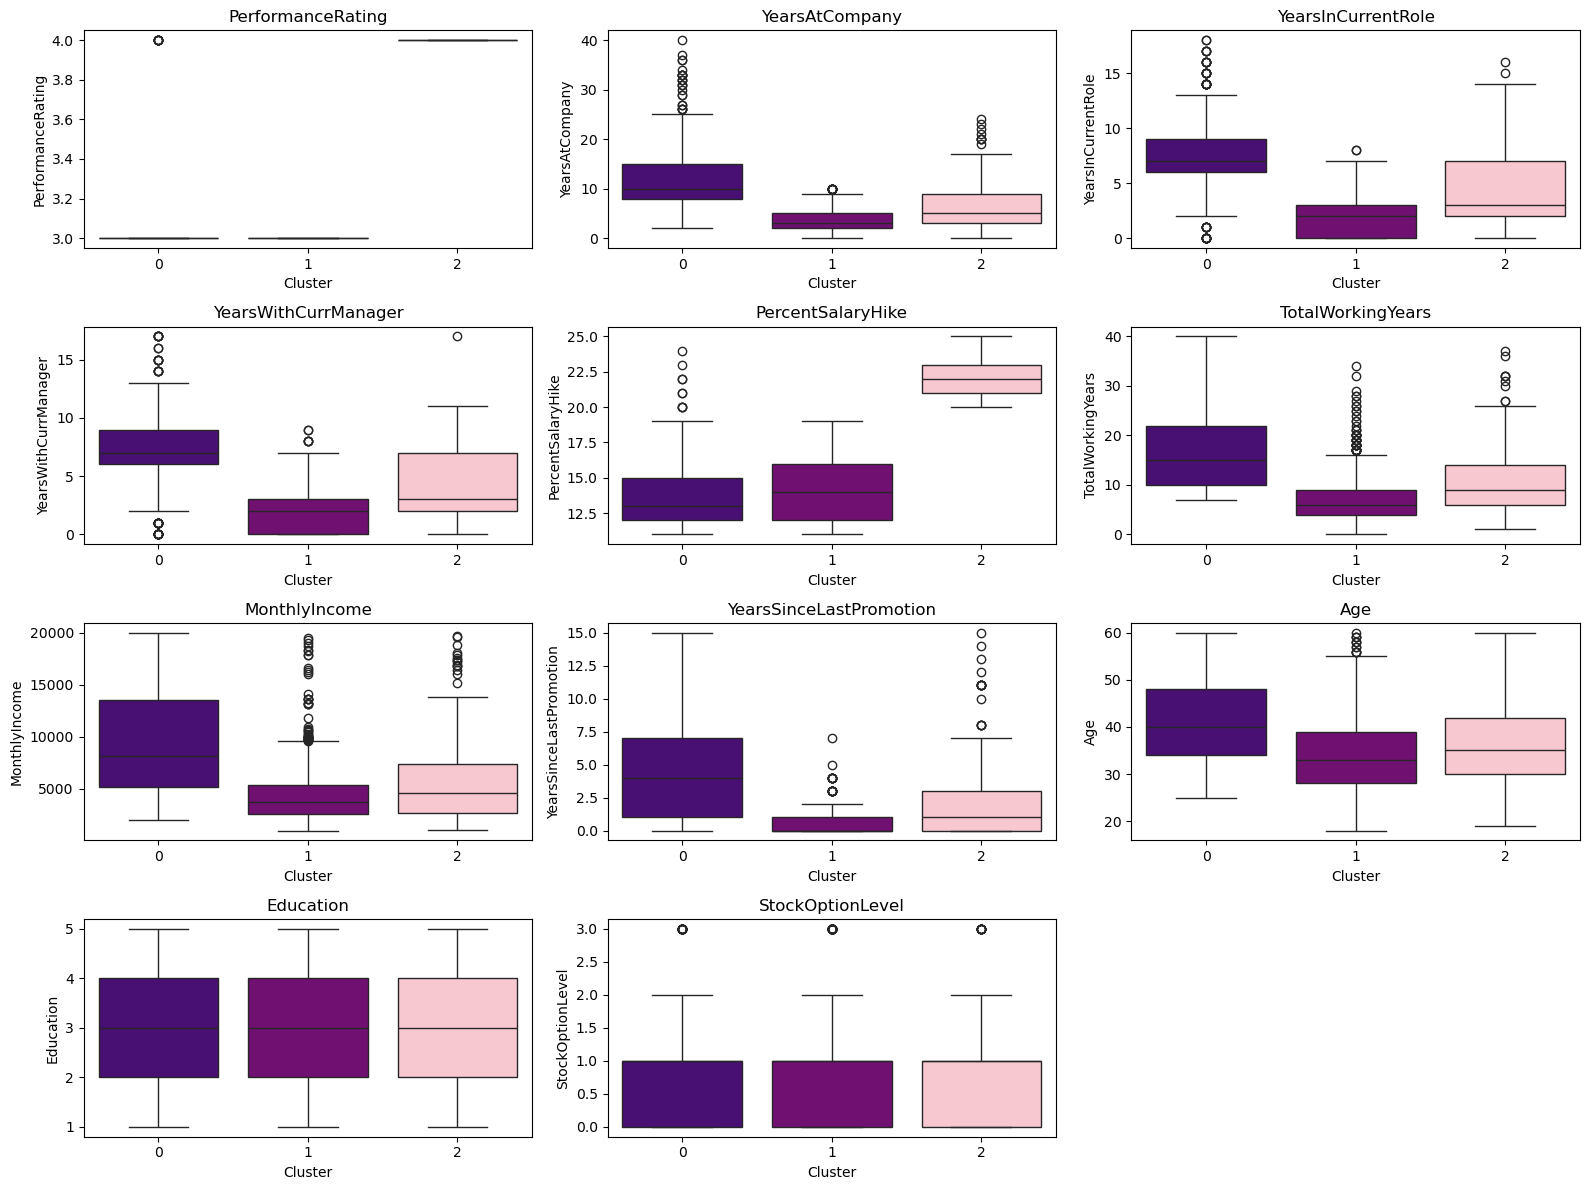

In [106]:
# Boxplot is drawn to visualize different significant features in each cluster (Numeric Only)
import matplotlib.pyplot as plt
import seaborn as sns

# Indigo, Purple and Blush Pink
custom_palette = ["#4B0082", "#800080", "#FFC0CB"]

# Select P < 0.05 Features: Only select features with significant impacts on Attrition
significant_features = anova_results[anova_results["P-Value"] < 0.05]["Feature"].tolist() 
significant_numeric = [feat for feat in significant_features if feat not in ['Attrition', 'MaritalStatus']]

fig, axes = plt.subplots(4, 3, figsize=(16, 12)) 
axes = axes.flatten()

# Boxplot
for i, feature in enumerate(significant_numeric):
    sns.boxplot(x=df1["Cluster"], y=df1[feature], ax=axes[i], palette=custom_palette)
    axes[i].set_title(feature)
    
for j in range(i + 1, len(axes)):  
    fig.delaxes(axes[j])  

plt.tight_layout()
plt.show()

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_16016\150268116.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df1, x=feature, hue="Cluster", fill=True, common_norm=False, ax=ax)


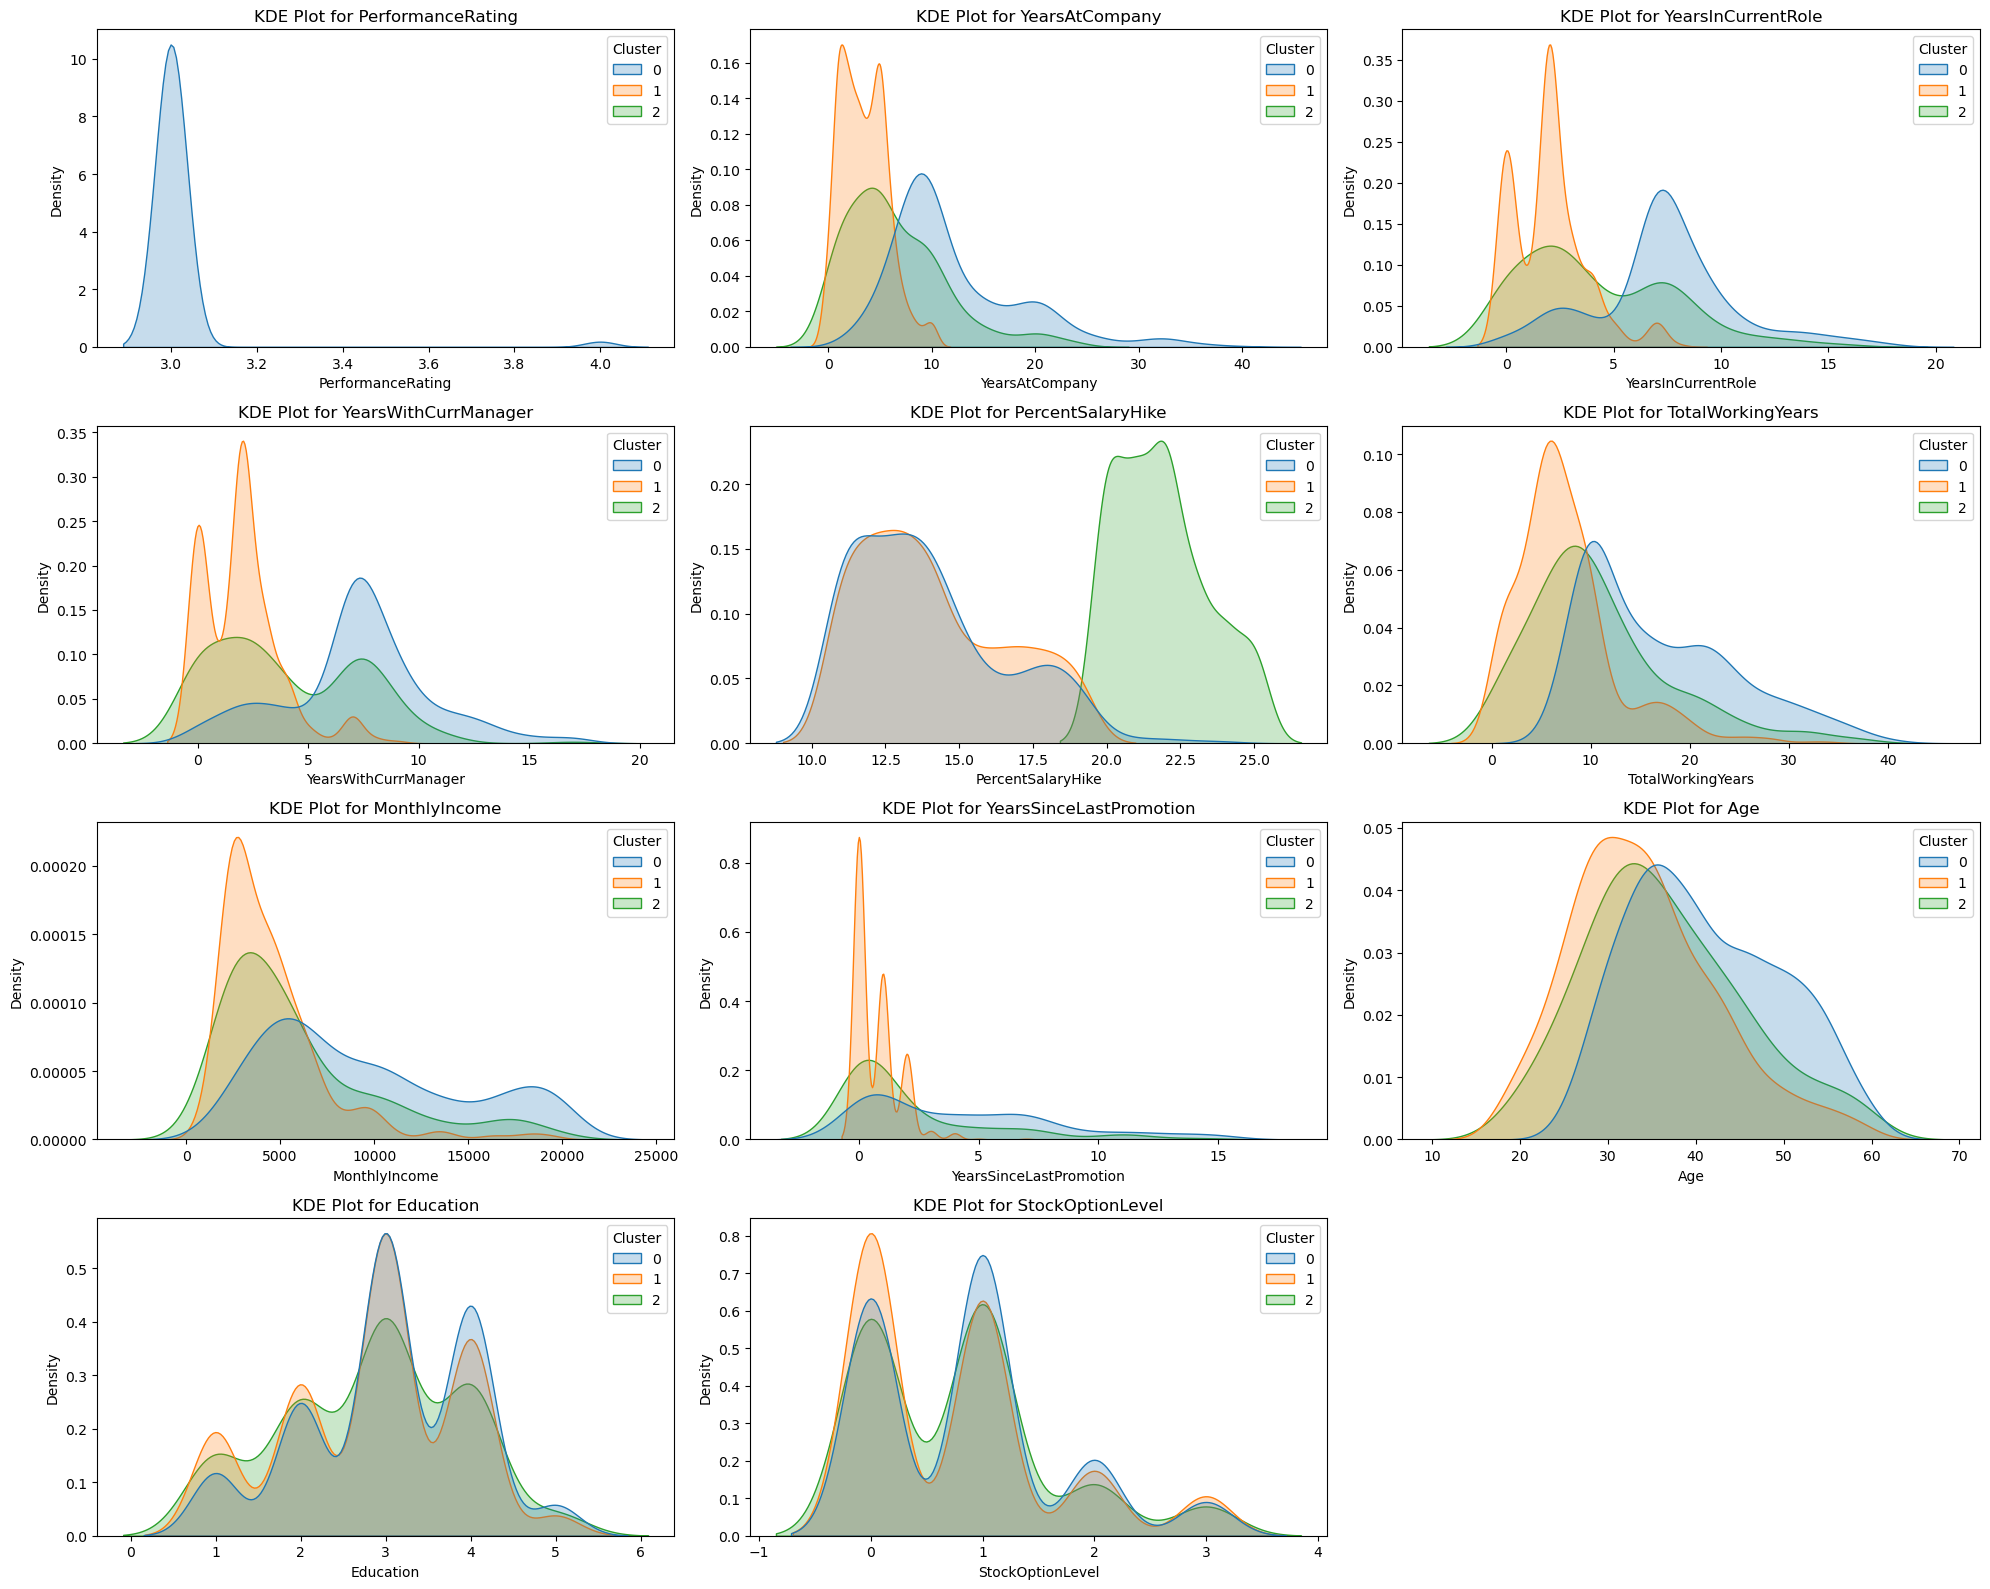

In [108]:
# KDE Plot is drawn to understand the distribution of data in different numerical ranges (Numeric Only)
n_cols = 3
n_rows = 4

fig, axes = plt.subplots(4, 3, figsize=(20, 16))

# KDE Plot
for i, feature in enumerate(significant_numeric):
    row, col = divmod(i, n_cols)
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    sns.kdeplot(data=df1, x=feature, hue="Cluster", fill=True, common_norm=False, ax=ax)
    ax.set_title(f"KDE Plot for {feature}")

for j in range(i + 1, 4 * 3):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

C:\Users\Yuriii\AppData\Local\Temp\ipykernel_6964\2713875183.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_counts = df1.groupby(["Cluster", feature]).size().unstack()
C:\Users\Yuriii\AppData\Local\Temp\ipykernel_6964\2713875183.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_counts = df1.groupby(["Cluster", feature]).size().unstack()


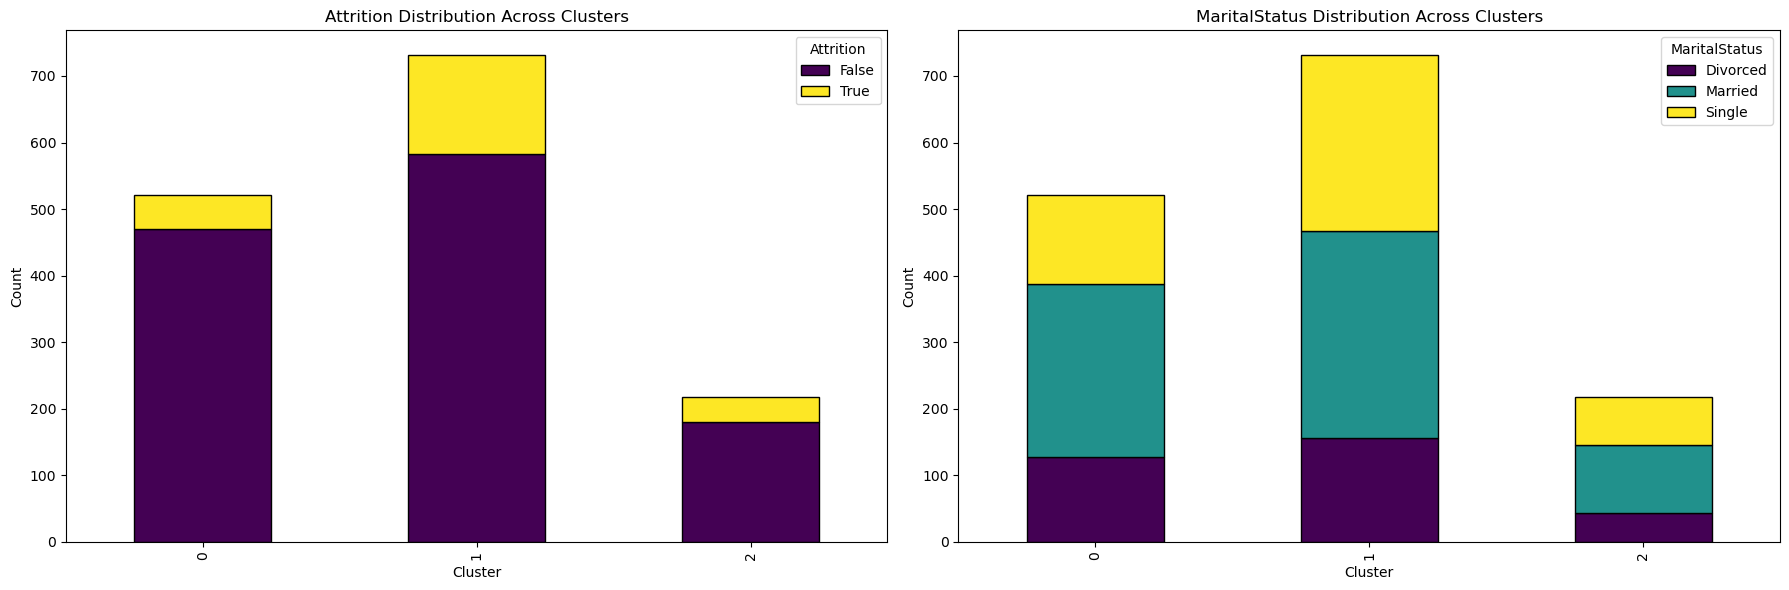

In [77]:
# Stacked Bar Chart is drawn to help gain insights (Attrition and significant categorical feature MaritalStatus)
sig_categorical = ['Attrition', 'MaritalStatus']

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Stacked Bar Chart
for i, feature in enumerate(sig_categorical):
    ax = axes[i]
    
    cluster_counts = df1.groupby(["Cluster", feature]).size().unstack()
    
    cluster_counts.plot(kind="bar", stacked=True, ax=ax, colormap="viridis", edgecolor="black")
    
    ax.set_title(f"{feature} Distribution Across Clusters")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Count")
    ax.legend(title=feature)

plt.tight_layout()
plt.show()

In [78]:
# Chi-Square Test is applied to check whether there is a significant relationship between Attrition and Cluster
from scipy.stats import chi2_contingency

# Calculate Attrition in Different Clusters
attrition_table = pd.crosstab(df1["Cluster"], df1["Attrition"])

# chi-square check for Attrition importance
chi2, p, dof, expected = chi2_contingency(attrition_table)

print(f"Chi-Square Test P-Value for Attrition: {p}")

Chi-Square Test P-Value for Attrition: 3.2222887495604383e-06


Chi-Square Test result shows that the p-value is less than 0.05, which indicates there is a **significant relationship between Attrition and Cluster**.

**Cluster centroids**

In [80]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df_pca.columns)
centroids

,YearsAtCompany,PerformanceRating,PercentSalaryHike,StockOptionLevel,JobSatisfaction,WorkLifeBalance,DistanceFromHome,EnvironmentSatisfaction,TrainingTimesLastYear,RelationshipSatisfaction,...,WorkLifeBalance,DistanceFromHome,HourlyRate,Education,NumCompaniesWorked,NumCompaniesWorked,YearsSinceLastPromotion,Age,EducationField_Life Sciences,BusinessTravel_Travel_Rarely
0,1.984959,-0.204735,-0.495977,0.008155,0.058418,-0.006086,0.024478,-0.011924,0.017184,0.059364,...,-0.048310,-0.000053,-0.000887,-0.017902,0.000337,-0.027872,0.006417,0.017956,0.027432,-0.010413
1,-1.367864,-0.508537,-0.223250,0.025144,-0.010292,0.003714,0.022251,0.038577,0.000796,-0.039782,...,0.048925,0.018311,-0.016583,0.009635,-0.006059,0.007510,-0.005805,-0.010258,-0.022023,0.003777
2,-0.151555,2.206987,1.943885,-0.104396,-0.105540,0.002084,-0.133828,-0.101503,-0.043940,-0.008333,...,-0.049050,-0.061640,0.058070,0.010480,0.019631,0.041585,0.004174,-0.008509,0.008428,0.012259


In [81]:
top_features = centroids.abs().idxmax(axis=1)
centroids_df = centroids.copy()
centroids_df["Key Feature"] = top_features

In [82]:
# Key features for each cluster
centroids_df["Key Feature"]

0       YearsAtCompany
1       YearsAtCompany
2    PerformanceRating
Name: Key Feature, dtype: object

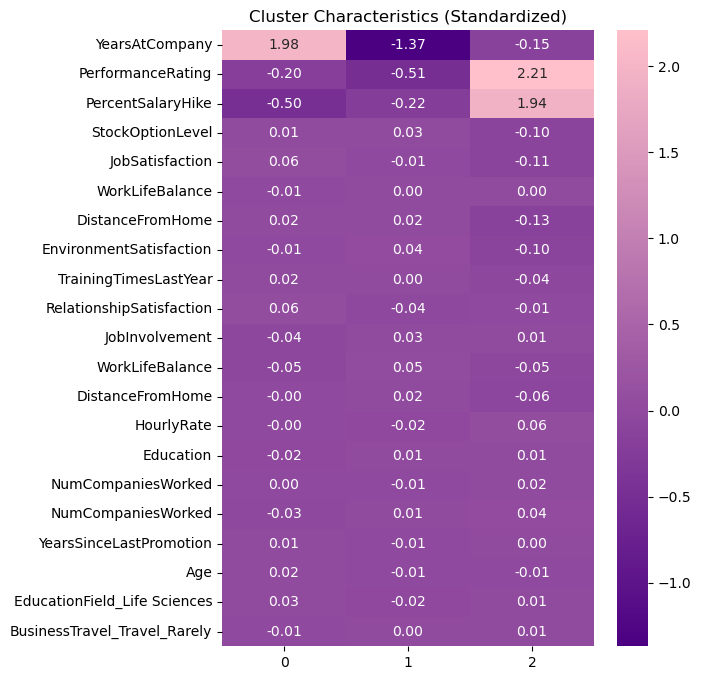

In [105]:
# Heatmap to help identify key features
import matplotlib.colors as mcolors
indigo_blush_cmap = mcolors.LinearSegmentedColormap.from_list("indigo_blush", ["#4B0082", "#FFC0CB"])

plt.figure(figsize=(6, 8))
sns.heatmap(centroids.T, cmap=indigo_blush_cmap, annot=True, fmt=".2f")
plt.title("Cluster Characteristics (Standardized)")
plt.show()

### **Heatmap Interpretation Note**
From the heatmap, we can see the standardized means (Z-scores) for each cluster across different features.  
- **A Z-score > 0** means the feature value is **higher than the average** for that cluster.
- **A Z-score < 0** means the feature value is **lower than the average** for that cluster.

In [423]:
df_clustering = df.copy()
df_count = df_clustering.groupby(by=["Cluster"]).size().reset_index(name="counts")
df_count

,Cluster,counts
0,0,521
1,1,732
2,2,217


In [415]:
attrition_rates

Attrition,No,Yes
Cluster,,
0,90.211132,9.788868
1,79.644809,20.355191
2,82.949309,17.050691


In [83]:
import pandas as pd

# Calculate Variance
feature_variation = centroids.var(axis=0)
top_features_Z = feature_variation.idxmax()

print("Top Differentiating Feature:", top_features_Z)

Top Differentiating Feature: YearsAtCompany


## **Cluster Characteristics**

### **Cluster 0**
**Key Characteristics**
- YearsAtCompany (1.98): These employees have been with the company for a long time.
- PercentSalaryHike (-0.50): Their salary increase is below average.
- PerformanceRating (-0.20): Their performance ratings are slightly lower than other clusters.

**Business Insights**
- This cluster represents long-tenured employees who have stayed at the company for a significant period.
- Salary growth is relatively low, which could indicate limited career progression opportunities.
- Since performance ratings are slightly lower, they might be experiencing burnout or reduced motivation.

**Attrition Impact**
- Lowest attrition rate (9.78%) indicates that these employees are more likely to stay with the company, possibly due to job security, familiarity, or high switching costs.

**HR/Management Recommendations**
- Focus on **career growth opportunities**: if these employees feel stuck, they might leave in the future.  
- Offer **skill development programs and new responsibilities** to keep them engaged and productive.



### **Cluster 1**
**Key Characteristics**
- YearsAtCompany (-1.37): They have the shortest tenure in the company.
- PerformanceRating (-0.51): These employees have the lowest performance ratings.
- PercentSalaryHike (-0.22): Their salary increases are slightly below average.

**Business Insights**
- This cluster likely represents new or struggling employees:
  - They are relatively new to the company and still adjusting.
  - Their performance ratings are low, indicating either a lack of skills, engagement issues, or misalignment with the role.
  - Their salary increase is slightly below average, suggesting limited investment from the company.

**Attrition Impact**
- Highest attrition rate (20.35%) could be opportunity-driven attrition.
- Their attrition is likely due to early-stage job dissatisfaction, lack of career direction, or feeling they are not a good fit.

**HR/Management Recommendations**
- Strengthen **career development and performance management** for new employees.  
- Implement a **mentorship program** to accelerate their learning and integration into the company.  
- Consider **job rotation** to see if they are better suited for different roles.



### **Cluster 2**
**Key Characteristics**
- YearsAtCompany (-0.15): They have the shortest tenure in the company.
- PerformanceRating (2.21): These employees have the highest performance ratings.
- PercentSalaryHike (1.94): They also receive the largest salary increases.

**Business Insights**
- This cluster consists of high-performing employees who are likely top talent in the company.
- Since salary growth is high, the company is actively rewarding them, which suggests they are critical contributors.
- However, this cluster has the highest attrition rate (20.35%), meaning that despite receiving salary increases, they are still leaving.

**Attrition Impact**
- Moderate attrition rate (17.05%), higher than Cluster 0 but lower than Cluster 1.
  - These employees have high market value and can easily find better opportunities.
  - They might have higher career aspirations that the company is not fulfilling.

**HR/Management Recommendations**
- Salary increases alone are not enough to retain top talent, **career advancement, challenging assignments, and leadership roles** are crucial.  
- Implement **high-potential leadership programs** and **structured career progression plans**.  
- Consider having interviews with them to understand their long-term career goals and proactively address their concerns.

## **Overall Business Strategy**
**Cluster 0 (Long-tenured employees)**
   - They are stable for now, but if salary growth remains low, their attrition rate might rise in the future.
   - **HR should focus on career development and re-engagement programs**.

**Cluster 1 (Low-performing newcomers)**
   - **They have the highest attrition rate**, which is likely due to **poor role fit or early job dissatisfaction**.
   - **Providing better onboarding, mentorship, and career coaching could improve retention**.

**Cluster 2 (High performers)**
   - They are **key contributors** in the company with **medium attrition rate**.
   - **HR should prioritize retention strategies beyond salary**, such as leadership development and career growth.